# Objective

The objective of this assignment is to build and compare sentiment classification models using Bag of Words (CountVectorizer) and TF-IDF Vectorizer on the financial news dataset. This involves performing text preprocessing, generating feature representations using both vectorization methods, training Random Forest classifiers, and evaluating their performance using accuracy, precision, recall, F1-score, and confusion matrices. The goal is to understand how different text-representation techniques impact sentiment-classification effectiveness and to document these insights in a structured report.

### Importing all the required Libraries

In [162]:
import sys
import pandas as pd
import sklearn
import matplotlib
import seaborn as sns
import spellchecker   # pyspellchecker
from collections import Counter
import re
import string
import os
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from spellchecker import SpellChecker
import time
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

### Printing Libraries version 

In [164]:
print("Python version:", sys.version)
print("pandas version:", pd.__version__)
print("scikit-learn version:", sklearn.__version__)
print("matplotlib version:", plt.matplotlib.__version__)
print("seaborn version:", sns.__version__)
print("pyspellchecker version:", spellchecker.__version__)
print("nltk version:", nltk.__version__)

Python version: 3.12.7 | packaged by Anaconda, Inc. | (main, Oct  4 2024, 13:17:27) [MSC v.1929 64 bit (AMD64)]
pandas version: 2.2.2
scikit-learn version: 1.5.1
matplotlib version: 3.9.2
seaborn version: 0.13.2
pyspellchecker version: 0.8.3
nltk version: 3.9.1


### Importing the Dataset and setting the path to it.

In [476]:
# Construct the full path to the CSV file
csv_file_path = os.path.join(file_path, 'all-data.csv')

# Load the CSV into a pandas DataFrame
df = pd.read_csv(r'D:\GLIMS\Term_5\NLP\all-data.csv', encoding='latin-1', header=None)

### Renaming DataFrame Columns for better usage and seeing the top 5 rows.

In [478]:
df.rename(columns={0: 'sentiment', 1: 'review'}, inplace=True)
df = df[['review', 'sentiment']]
display(df.head())

,review,sentiment
0,"According to Gran , the company has no plans t...",neutral
1,Technopolis plans to develop in stages an area...,neutral
2,The international electronic industry company ...,negative
3,With the new production plant the company woul...,positive
4,According to the company 's updated strategy f...,positive


In [286]:
text_train = df['review']
y_train = df['sentiment']

In [288]:
display(text_train.head())

0    According to Gran , the company has no plans t...
1    Technopolis plans to develop in stages an area...
2    The international electronic industry company ...
3    With the new production plant the company woul...
4    According to the company 's updated strategy f...
Name: review, dtype: object

In [290]:
display(y_train.head())

0     neutral
1     neutral
2    negative
3    positive
4    positive
Name: sentiment, dtype: object

In [226]:
print("Shape of text_train:", text_train.shape)
print("Shape of y_train:", y_train.shape)

Shape of text_train: (4846,)
Shape of y_train: (4846,)


# Text Cleaning

### Define a Python function that preprocesses text by converting it to lowercase, removing URLs, stripping HTML tags, eliminating non-alphanumeric characters (except spaces), and collapsing extra spaces, then apply this function to the text_train data.



In [292]:
def get_your_review_cleaned(text):
    """
    Cleans a given text string by applying the following steps:
    1. Converts text to lowercase
    2. Removes URLs
    3. Strips HTML tags
    4. Removes non-alphanumeric characters (keeps spaces)
    5. Collapses multiple spaces into one
    """
    
    if not isinstance(text, str):
        return ""   # safety check for non-string inputs

    # 1. Convert to lowercase
    text = text.lower()

    # 2. Remove URLs (supports http, https, www)
    text = re.sub(r'https?://\S+|www\.\S+', '', text)

    # 3. Remove HTML tags
    text = re.sub(r'<.*?>', '', text)

    # 4. Remove all non-alphanumeric characters except spaces
    text = re.sub(r'[^a-z0-9 ]+', '', text)

    # 5. Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()

    return text


#### Testing the function with an example

In [303]:
example_sentiment = "WOW!!! <div>Absolutely terrible</div> service... Check details: https://abc.org/info?id=9999   @@@  "
cleaned_example_sentiment = get_your_review_cleaned(example_sentiment)

print("Original Text:", example_sentiment)
print("Cleaned Text:", cleaned_example_sentiment)

Original Text: WOW!!! <div>Absolutely terrible</div> service... Check details: https://abc.org/info?id=9999   @@@  
Cleaned Text: wow absolutely terrible service check details


#### We will apply this function to the text_train.

In [311]:
text_train = text_train.apply(get_your_review_cleaned)
print("\nCleaned text_train head (first 5 entries):")
display(text_train.head())

y_train = y_train.apply(get_your_review_cleaned)
print("\nCleaned y_train head (first 5 entries):")
display(y_train.head())


Cleaned text_train head (first 5 entries):


0    according to gran the company has no plans to ...
1    technopolis plans to develop in stages an area...
2    the international electronic industry company ...
3    with the new production plant the company woul...
4    according to the company s updated strategy fo...
Name: review, dtype: object


Cleaned y_train head (first 5 entries):


0     neutral
1     neutral
2    negative
3    positive
4    positive
Name: sentiment, dtype: object

### Punctuation Removal

In [325]:
# List of standard Python punctuation characters
PUNCT_TO_REMOVE = string.punctuation  


def remove_punctuations(text):
    """
    Removes all punctuation characters from a given text string using str.translate().
    
    Args:
        text (str): Input text
    
    Returns:
        str: Text with all punctuation removed
    """
    
    if not isinstance(text, str):
        return ""  # Safety check for non-string inputs
    
    # Create a translation table that removes all punctuation
    translation_table = str.maketrans('', '', PUNCT_TO_REMOVE)
    
    return text.translate(translation_table)


# -------------------------------
# Example usage
# -------------------------------
text = "Hurray!!! This product is amazing :) #awesome"
cleaned_text = remove_punctuation(text)

print("Original:", text)
print("Without punctuation:", cleaned_text)

Original: Hurray!!! This product is amazing :) #awesome
Without punctuation: Hurray This product is amazing  awesome


In [327]:
text_train = text_train.apply(remove_punctuations)

print("Original text_train head (first 5 entries):")
display(text_train.head())

Original text_train head (first 5 entries):


0    according to gran the company has no plans to ...
1    technopolis plans to develop in stages an area...
2    the international electronic industry company ...
3    with the new production plant the company woul...
4    according to the company s updated strategy fo...
Name: review, dtype: object

### Removing StopWords

In [335]:
# Convert to set
stop_words = set(ENGLISH_STOP_WORDS)
print(stop_words)

{'three', 'whose', 'anyhow', 'if', 'none', 'one', 'be', 'while', 'everywhere', 'this', 'an', 'fire', 'please', 'most', 'nothing', 'very', 'anything', 'whole', 'he', 'above', 'was', 'which', 'thus', 'that', 'herself', 'call', 'how', 'four', 'own', 'amount', 'go', 'upon', 'empty', 'will', 'you', 'such', 'amongst', 'further', 'but', 'somehow', 'therefore', 'inc', 'among', 'who', 'thereupon', 'ours', 'those', 'sometimes', 'these', 'already', 'have', 'mine', 'ie', 'beyond', 'not', 'up', 'along', 'can', 'his', 'myself', 'thereby', 'here', 'well', 'sometime', 'they', 'i', 'whatever', 'always', 'thence', 'anyone', 'so', 'enough', 'all', 'no', 'then', 'sincere', 'because', 'eg', 'give', 'con', 'being', 'yourself', 'first', 'nor', 'together', 'whoever', 'wherein', 'ever', 'nobody', 'never', 'thin', 'twelve', 'us', 'rather', 'at', 'each', 'serious', 'fifty', 'where', 'eleven', 'into', 'hence', 'within', 'even', 'would', 'formerly', 'over', 'hers', 'your', 'alone', 'ltd', 'detail', 'itself', 'desc

#### Find the top 50 most common words

In [343]:
all_text = " ".join(text_train)

# Keep only words (remove punctuation)
words = re.findall(r'\b\w+\b', all_text)

word_counts = Counter(words)

# Show most common 50 words
print(word_counts.most_common(70))

top_70_words = [word for word, count in word_counts.most_common(70)]
top_70_set = set(top_70_words)

[('the', 6066), ('of', 3213), ('in', 2969), ('and', 2593), ('to', 2509), ('a', 1723), ('for', 1151), ('s', 1045), ('eur', 1015), ('is', 928), ('will', 850), ('company', 848), ('from', 768), ('on', 680), ('its', 646), ('has', 578), ('with', 573), ('by', 558), ('as', 548), ('said', 544), ('be', 542), ('mn', 515), ('finnish', 512), ('at', 480), ('it', 472), ('sales', 453), ('million', 440), ('that', 434), ('net', 412), ('profit', 409), ('was', 370), ('finland', 337), ('an', 326), ('group', 320), ('m', 300), ('operating', 299), ('2009', 297), ('mln', 288), ('are', 286), ('2008', 283), ('year', 274), ('new', 267), ('business', 265), ('period', 264), ('2007', 243), ('oyj', 241), ('quarter', 238), ('2010', 238), ('share', 237), ('also', 224), ('services', 223), ('which', 221), ('have', 219), ('market', 217), ('shares', 198), ('first', 193), ('this', 193), ('up', 182), ('2006', 173), ('been', 167), ('euro', 164), ('helsinki', 163), ('loss', 153), ('about', 153), ('compared', 149), ('today', 14

In [345]:
common_words = top_70_set.intersection(stop_words)
print(common_words)

{'will', 'is', 'as', 'and', 'to', 'be', 'are', 'it', 'with', 'first', 'its', 'has', 'a', 'this', 'the', 'an', 'been', 'have', 'about', 'also', 'at', 'up', 'by', 'from', 'on', 'was', 'which', 'for', 'of', 'that', 'in'}


In [347]:
new_stopwords = top_70_set.difference(stop_words)
print(new_stopwords)

{'finnish', 'new', 'share', 'operations', 'market', 'profit', 'company', 's', 'eur', 'finland', 'sales', 'quarter', 'said', 'period', 'm', '2007', 'operating', '2009', '2008', 'compared', 'net', 'nokia', 'oyj', 'business', 'contract', 'euro', 'million', 'loss', 'mn', 'today', 'helsinki', 'services', 'year', 'total', 'group', '2010', 'shares', '2006', 'mln'}


In [349]:
custom_stopwords = {'s','said''2006','2007','2008','2009','2010','company','eur','inc','corp','group','firm','industry','production','products','corporation','companies','technology','financial','plant','percent','according','bank','based','market','business','production','product','shares','stock'}

#### Updating the Stopwords

In [351]:
stop_words.update(custom_stopwords)
print(stop_words)

{'three', 'percent', 'corp', 'whose', 'anyhow', 'if', 'none', 'one', 'be', 'while', 'everywhere', 'this', 'an', 'fire', 'please', 'most', 'nothing', 'very', 'anything', 'whole', 'he', 'above', 'was', 'which', 'thus', 'financial', 'product', 'that', 'herself', '2010', 'call', 'how', 'four', 'own', 'amount', 'go', 'upon', 'empty', 'will', 'you', 'such', 'amongst', 'further', 'but', 'somehow', 'therefore', 'inc', 'among', 'who', 'thereupon', 'ours', '2009', 'those', 'sometimes', 'these', 'already', 'have', 'mine', 'ie', 'beyond', 'not', 'up', 'along', 'can', 'his', 'myself', 'thereby', 'here', 'well', 'sometime', 'products', 'they', 'i', 'whatever', 'always', 'thence', 'anyone', 'so', 'enough', 'companies', 'all', 'no', 'then', 'market', 'sincere', 'because', 'eg', 'eur', 'give', 'con', 'being', 'yourself', 'first', 'nor', 'together', 'whoever', 'wherein', 'ever', 'nobody', 'never', 'thin', 'twelve', 'us', 'rather', 'at', 'each', 'business', 'serious', 'fifty', 'corporation', 'where', 'el

#### Removing words from stopwords

In [353]:
stop_words.discard('no')
stop_words.discard('except')
stop_words.discard('cannot')
print(stop_words)

{'three', 'percent', 'corp', 'whose', 'anyhow', 'if', 'none', 'one', 'be', 'while', 'everywhere', 'this', 'an', 'fire', 'please', 'most', 'nothing', 'very', 'anything', 'whole', 'he', 'above', 'was', 'which', 'thus', 'financial', 'product', 'that', 'herself', '2010', 'call', 'how', 'four', 'own', 'amount', 'go', 'upon', 'empty', 'will', 'you', 'such', 'amongst', 'further', 'but', 'somehow', 'therefore', 'inc', 'among', 'who', 'thereupon', 'ours', '2009', 'those', 'sometimes', 'these', 'already', 'have', 'mine', 'ie', 'beyond', 'not', 'up', 'along', 'can', 'his', 'myself', 'thereby', 'here', 'well', 'sometime', 'products', 'they', 'i', 'whatever', 'always', 'thence', 'anyone', 'so', 'enough', 'companies', 'all', 'then', 'market', 'sincere', 'because', 'eg', 'eur', 'give', 'con', 'being', 'yourself', 'first', 'nor', 'together', 'whoever', 'wherein', 'ever', 'nobody', 'never', 'thin', 'twelve', 'us', 'rather', 'at', 'each', 'business', 'serious', 'fifty', 'corporation', 'where', 'eleven',

In [373]:
def remove_stopwords(text):
    """custom function to remove the stopwords"""

    return " ".join([word for word in str(text).split() if word not in stop_words])

In [365]:
text_train = text_train.apply(remove_stopwords)
print("Stopwords Removed!")
display(text_train.head())

Stopwords Removed!


0                         gran no plans russia growing
1    technopolis plans develop stages area no 10000...
2    international electronic elcoteq laid tens emp...
3    new increase capacity meet expected increase d...
4    updated strategy years 20092012 basware target...
Name: review, dtype: object

### Spell Check

In [368]:
spell = SpellChecker()

def correct_sentence(text):
    try:
        # If the value is None, NaN, or not a string → return empty string
        if text is None or not isinstance(text, str):
            return ""

        corrected_words = []
        for word in text.split():
            corrected_words.append(spell.correction(word))
        return " ".join(corrected_words)

    except Exception as e:
        # If something unexpected happens, return text unchanged
        #print(f"Error correcting text: {text}  |  Error: {e}")
        return text

#### Adding a custom logic that since Spell Check takes a lot of time to complete it's execution and in between if the kernel dies we need to run the execution again, therefore added a custom logic in which I first ran the spell check function and saved it in the system, now if the kernel dies and I need to run the code again, then first it will check the save excel file is present or not. If present, then no need to run the Spell Check logic again, in no, then run the spell check logic.

In [472]:
# Path to your saved corrected file
checkpoint_xlsx = r"D:/GLIMS/Term_5/NLP/checkpoint.xlsx"

# CASE 1: If Excel exists → load and SKIP the loop
if os.path.exists(checkpoint_xlsx):
    print("✔ Processed Excel found. Loading and skipping the loop...")
    text_train = pd.read_excel(checkpoint_xlsx, engine="openpyxl")
    print("✔ Loaded corrected data from:", checkpoint_xlsx)

# CASE 2: If Excel does NOT exist → run the loop & save
else:
    print("No processed Excel found. Running correction loop...")

    # Load the original file
    df = pd.read_csv(input_csv, encoding="windows-1252")
    text_train = df.copy()

    # Run your spell-correction loop
    text_train = text_train.apply(correct_sentence)

    # Save final corrected output
    text_train.to_excel(checkpoint_xlsx, index=False, engine="openpyxl")
    print("✔ Correction complete. Saved to:", checkpoint_xlsx)


✔ Processed Excel found. Loading and skipping the loop...
✔ Loaded corrected data from: D:/GLIMS/Term_5/NLP/checkpoint.xlsx


### Replace Acronyms with Full Forms

#### Since we are getting the financial news headings, we will using the financial acronyms over here.

In [398]:
chat_word_dict = {}

chat_word_dict = {
    # ---- Time & Comparison ----
    "YTD": "Year To Date",
    "YOY": "Year Over Year",
    "YY": "Year Over Year",
    "QOQ": "Quarter Over Quarter",
    "QQ": "Quarter Over Quarter",
    "WOW": "Week Over Week",
    "WW": "Week Over Week",
    "MOM": "Month Over Month",
    "MM": "Month Over Month",
    "DOD": "Day Over Day",
    "DD": "Day Over Day",

    # ---- Stock Market & Trading ----
    "PT": "Price Target",
    "TP": "Target Price",
    "EPS": "Earnings Per Share",
    "PE": "Price To Earnings Ratio",
    "P/E": "Price To Earnings Ratio",
    "ETF": "Exchange Traded Fund",
    "ADR": "American Depositary Receipt",
    "IPO": "Initial Public Offering",
    "FII": "Foreign Institutional Investors",
    "FPI": "Foreign Portfolio Investors",
    "DII": "Domestic Institutional Investors",
    "NAV": "Net Asset Value",
    "ROI": "Return On Investment",
    "PBT": "Profit Before Tax",
    "PAT": "Profit After Tax",
    "FCF": "Free Cash Flow",

    # ---- Corporate Results ----
    "EBIT": "Earnings Before Interest and Taxes",
    "EBITDA": "Earnings Before Interest, Taxes, Depreciation, and Amortization",
    "GM": "Gross Margin",
    "OM": "Operating Margin",
    "REV": "Revenue",
    "REVS": "Revenues",
    "FY": "Fiscal Year",
    "Q1": "Quarter 1",
    "Q2": "Quarter 2",
    "Q3": "Quarter 3",
    "Q4": "Quarter 4",
    "H1": "First Half",
    "H2": "Second Half",
    "DPS": "Dividend Per Share",

    # ---- Company Identifiers ----
    "LTD": "Limited",
    "INC": "Incorporated",
    "CO": "Company",
    "CORP": "Corporation",
    "PLC": "Public Limited Company",
    "LLC": "Limited Liability Company",
    "LLP": "Limited Liability Partnership",
    "AG": "Aktiengesellschaft",
    "NV": "Naamloze Vennootschap",
    "SA": "Sociedad Anónima",
    "OYJ": "Public Company (Finnish)",

    # ---- Banking, Economics & Policy ----
    "GDP": "Gross Domestic Product",
    "PMI": "Purchasing Managers Index",
    "CPI": "Consumer Price Index",
    "WPI": "Wholesale Price Index",
    "PPI": "Producer Price Index",
    "RBI": "Reserve Bank of India",
    "FED": "Federal Reserve",
    "ECB": "European Central Bank",
    "IMF": "International Monetary Fund",
    "FOMC": "Federal Open Market Committee",
    "OPEC": "Organization of the Petroleum Exporting Countries",
    "BOE": "Bank of England",
    "FDI": "Foreign Direct Investment",

    # ---- Corporate Actions & Finance ----
    "AGM": "Annual General Meeting",
    "EGM": "Extraordinary General Meeting",
    "ROE": "Return On Equity",
    "ROA": "Return On Assets",
    "WACC": "Weighted Average Cost Of Capital",
    "LBO": "Leveraged Buyout",
    "M&A": "Mergers and Acquisitions",
    "FTA": "Free Trade Agreement",

    # ---- Newswire shorthand ----
    "M": "Million",
    "MN": "Million",
    "MIO": "Million",
    "BN": "Billion",
    "B": "Billion",
    "BIL": "Billion",
    "MIL": "Million",
    "PCT": "Percent",
    "VS": "Versus",
    "PCPT": "Percentage Point",
    "PCPTS": "Percentage Points",

    # ---- Executive Titles ----
    "CEO": "Chief Executive Officer",
    "CFO": "Chief Financial Officer",
    "COO": "Chief Operating Officer",
    "CTO": "Chief Technology Officer",
    "CIO": "Chief Information Officer"

}

#### Identifying the Acronyms used in our data

In [416]:
chat_keys = set(chat_word_dict.keys())
found_chat_words = set()

for text in text_train['review']:
    if pd.isna(text):
        continue
    words = text.split()
    for w in words:
        if w.upper() in chat_keys:
            found_chat_words.add(w.upper())

print("Chat abbreviations found:")
print(found_chat_words)


Chat abbreviations found:
{'REVS', 'EBITDA', 'CTO', 'OYJ', 'OM', 'CEO', 'Q1', 'PLC', 'BN', 'EGM', 'CO', 'AG', 'MN', 'Q2', 'B', 'H1', 'EBIT', 'M', 'AGM', 'ADR', 'NV', 'YY', 'LLC', 'IPO', 'DD', 'SA', 'PCT', 'CFO', 'EPS'}


#### Defining the function for replacing the Acronyms.

In [420]:
def map_chatwords(text):
    # Skip anything that is not a string (NaN, numbers, Series, etc.)
    if not isinstance(text, str):
        return text

    words = text.split()
    new_words = []

    for w in words:
        key = w.upper()
        if key in chat_word_dict:
            new_words.append(chat_word_dict[key])
        else:
            new_words.append(w)

    return " ".join(new_words)


In [422]:
text_train = text_train.apply(map_chatwords)
print("Stopwords Removed!")
display(text_train.head())

Stopwords Removed!


,review
0,gran no plans russia growing
1,technopolis plans develop stages area no 10000...
2,international electronic elcoteq laid tens emp...
3,new increase capacity meet expected increase d...
4,updated strategy years 20092012 aware targets ...


### Splitting the data into Test and Train

In [424]:
text_train, text_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (3876,)
Shape of X_test: (970,)
Shape of y_train: (3876,)
Shape of y_test: (970,)


## Feature Engineering - Bag of Words(BoW)

#### Converting the cleaned text data into numerical feature vectors using the Bag-of-Words (BoW) model. This process tokenizes the text and counts how often each word appears, resulting in a matrix where each row corresponds to a document and each column corresponds to a unique word in the vocabulary.

In [438]:
#    Initialize CountVectorizer for Bag-of-Words (BoW)
#    We use the preprocessed text after acronym removal
bow_vectorizer = CountVectorizer()

#    Fit the vectorizer on the training data and transform it
text_train_bow = bow_vectorizer.fit_transform(text_train)

#    Transform the test data using the *already fitted* vectorizer
text_test_bow = bow_vectorizer.transform(text_test)

#    Display the shape of the resulting matrices
print("Shape of text_train_bow:", text_train_bow.shape)
print("Shape of text_test_bow:", text_test_bow.shape)


#    Display the first 10 feature names (words) to inspect vocabulary
print("\nFirst 10 features (words) from BoW vocabulary:")
feature_names = bow_vectorizer.get_feature_names_out()
print(feature_names[:10])

Shape of text_train_bow: (3876, 9570)
Shape of text_test_bow: (970, 9570)

First 10 features (words) from BoW vocabulary:
['00' '000' '000063' '0008' '001' '002' '0025' '003' '0030' '004']


## Model Construction and Evaluation: Random Forest with Bag-of-Words

#### Training a RandomForestClassifier using the Bag-of-Words (BoW) feature vectors. Once the model is trained, we evaluate its performance on the test set using standard classification metrics.

In [445]:

#    Initialize the RandomForestClassifier
#    Using a fixed random_state for reproducibility
rf_bow = RandomForestClassifier(random_state=42)

#    Train the model using the Bag-of-Words training features
print("Training Random Forest model with Bag-of-Words features...")
rf_bow.fit(text_train_bow, y_train)
print("Training complete.")

#    Generate predictions on the BoW-transformed test data
y_pred_bow = rf_bow.predict(text_test_bow)

#    Evaluate the model performance
print("\n--- Evaluation: Random Forest (Bag-of-Words) ---")
accuracy = accuracy_score(y_test, y_pred_bow)
print(f"Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_bow))


Training Random Forest model with Bag-of-Words features...
Training complete.

--- Evaluation: Random Forest (Bag-of-Words) ---
Accuracy: 0.7505

Classification Report:
              precision    recall  f1-score   support

    negative       0.74      0.44      0.55       110
     neutral       0.75      0.94      0.84       571
    positive       0.74      0.49      0.59       289

    accuracy                           0.75       970
   macro avg       0.75      0.62      0.66       970
weighted avg       0.75      0.75      0.73       970



## Feature Engineering: TF-IDF (Term Frequency-Inverse Document Frequency)

#### Convert the preprocessed text data into numerical feature vectors using the TF-IDF model. In this approach, each word is weighted based on how frequently it appears in a document and how rare it is across the entire corpus, so that uncommon but informative words receive higher importance than very frequent, less informative ones.

In [458]:
#    Initialize TfidfVectorizer
#    Using the preprocessed text after removing acronyms
tfidf_vectorizer = TfidfVectorizer()

#    Fit the vectorizer on the training data and transform it
text_train_tfidf = tfidf_vectorizer.fit_transform(text_train)

#    Transform the test data using the already fitted vectorizer
text_test_tfidf = tfidf_vectorizer.transform(text_test)

#    Display matrix shapes
print("Shape of text_train_tfidf:", text_train_tfidf.shape)
print("Shape of text_test_tfidf:", text_test_tfidf.shape)

# 5. Show the first 10 feature names to inspect vocabulary
print("\nFirst 10 features (words) from the TF-IDF vectorizer:")
feature_names = tfidf_vectorizer.get_feature_names_out()
print(feature_names[:10])

Shape of X_train_tfidf: (3876, 9570)
Shape of X_test_tfidf: (970, 9570)

First 10 features (words) from the TF-IDF vectorizer:
['00' '000' '000063' '0008' '001' '002' '0025' '003' '0030' '004']


## Model Construction and Evaluation: Random Forest with TF-IDF

#### Training a RandomForestClassifier using the TF-IDF feature representation. After training, we will evaluate its performance on the test set using various classification metrics and compare the results with those obtained from the Bag-of-Words (BoW) model.

In [460]:
#    Initialize the RandomForestClassifier
#    Using a fixed random_state for reproducibility

rf_tfidf = RandomForestClassifier(random_state=42)

#    Train the model using the TF-IDF training features

print("Training Random Forest model with TF-IDF features...")
rf_tfidf.fit(text_train_tfidf, y_train)
print("Training complete.")

#    Generate predictions on the TF-IDF-transformed test data
y_pred_tfidf = rf_tfidf.predict(text_test_tfidf)

#    Evaluate model performance
print("\n--- Evaluation: Random Forest (TF-IDF) ---")
accuracy = accuracy_score(y_test, y_pred_tfidf)
print(f"Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_tfidf))

Training Random Forest model with TF-IDF features...
Training complete.

--- Evaluation: Random Forest (TF-IDF) ---
Accuracy: 0.7536

Classification Report:
              precision    recall  f1-score   support

    negative       0.71      0.37      0.49       110
     neutral       0.75      0.95      0.84       571
    positive       0.77      0.52      0.62       289

    accuracy                           0.75       970
   macro avg       0.74      0.61      0.65       970
weighted avg       0.75      0.75      0.73       970



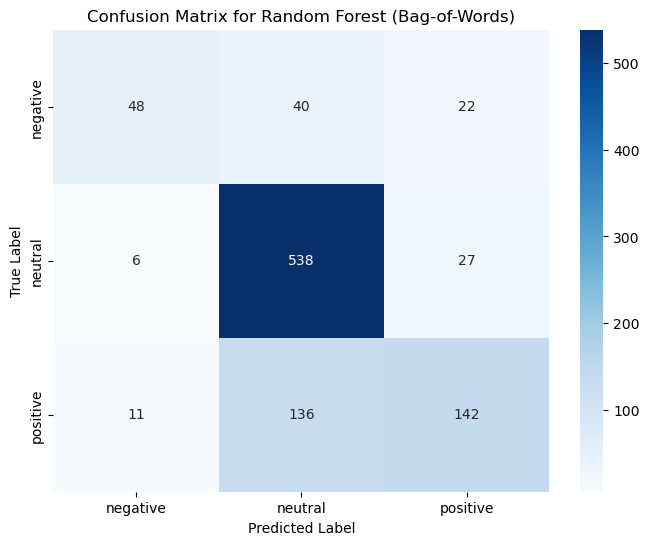

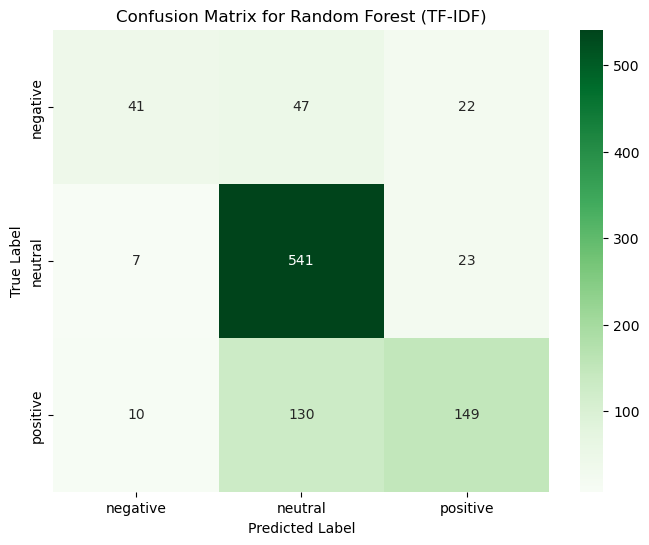

In [474]:
# --- Confusion Matrix for Random Forest (Bag-of-Words) ---
cm_bow = confusion_matrix(y_test, y_pred_bow)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_bow, annot=True, fmt='d', cmap='Blues',
            xticklabels=rf_bow.classes_, yticklabels=rf_bow.classes_)
plt.title('Confusion Matrix for Random Forest (Bag-of-Words)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# --- Confusion Matrix for Random Forest (TF-IDF) ---
cm_tfidf = confusion_matrix(y_test, y_pred_tfidf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_tfidf, annot=True, fmt='d', cmap='Greens',
            xticklabels=rf_tfidf.classes_, yticklabels=rf_tfidf.classes_)
plt.title('Confusion Matrix for Random Forest (TF-IDF)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## Comparative Analysis: Bag-of-Words vs. TF-IDF

We have successfully built and evaluated two Random Forest classifiers—one using Bag-of-Words (BoW) features and the other using TF-IDF features. Now, let's compare their performance metrics to understand how each feature representation impacts the model's effectiveness.

### 1. Random Forest with Bag-of-Words

**Accuracy:** 0.7505

**Classification Report:**
```
              precision    recall  f1-score   support

    negative       0.74      0.44      0.55       110
     neutral       0.75      0.94      0.84       571
    positive       0.74      0.49      0.59       289

    accuracy                           0.75       970
   macro avg       0.75      0.62      0.66       970
weighted avg       0.75      0.75      0.73       970
```

### 2. Random Forest with TF-IDF

**Accuracy:** 0.7536

**Classification Report:**
```
              precision    recall  f1-score   support

    negative       0.71      0.37      0.49       110
     neutral       0.75      0.95      0.84       571
    positive       0.77      0.52      0.62       289

    accuracy                           0.75       970
   macro avg       0.74      0.61      0.65       970
weighted avg       0.75      0.75      0.73       970
```

### Comparative Findings

1. **Overall Accuracy**

Both models achieved almost identical accuracy scores. The TF-IDF model (0.7536) performed marginally better than the Bag-of-Words model (0.7505), but the difference is extremely small and unlikely to be practically significant. This indicates that both feature representations allow the Random Forest classifier to learn sentiment patterns equally well.

2. **Precision and Recall (Class-wise)**

Negative Class

   * **BoW**: Precision = 0.74, Recall = 0.44, F1 = 0.55
   * **TF-IDF**: Precision = 0.71, Recall = 0.37, F1 = 0.49

The Bag-of-Words model performs slightly better on negative sentiment. Higher recall and F1-score indicate that BoW captures negative sentiment cues more effectively, reducing missed negative cases.

Neutral Class

   * **BoW**: Precision = 0.75, Recall = 0.94, F1 = 0.84
   * **TF-IDF**: Precision = 0.75, Recall = 0.95, F1 = 0.84

Both models perform almost identically on the neutral class, achieving excellent recall (0.94–0.95). This class dominates the dataset (571 samples), which explains why both vectorizers capture neutral patterns very reliably.

Positive Class

   * **BoW**: Precision = 0.74, Recall = 0.49, F1 = 0.59
   * **TF-IDF**: Precision = 0.77, Recall = 0.52, F1 = 0.62

The TF-IDF model performs slightly better on the positive class, achieving higher precision and recall. This suggests that TF-IDF gives better weightage to distinctive words that may signal positive sentiment.

3. **F1-Score (Macro & Weighted Averages)**

Macro F1:
   * **BoW**: 0.66
   * **TF-IDF**: 0.65

Weighted F1:
   * **BoW**: 0.73
   * **TF-IDF**: 0.73

Both macro and weighted F1-scores are nearly identical. This indicates that, overall, both models maintain a similar balance between precision and recall across all classes.

### Conclusion

In this sentiment analysis task using a Random Forest classifier, Bag-of-Words and TF-IDF performed very similarly, with no major differences in overall performance. The slight variations in class-wise results reveal the following:

* **BoW** shows a small advantage in detecting negative sentiment, demonstrating slightly higher recall and F1-score.

* **TF-IDF** performs marginally better at recognizing positive sentiment, likely due to its ability to assign higher weights to rare but meaningful words.

Both models consistently excel in identifying neutral statements, largely because the dataset contains a high proportion of neutral samples.

Overall, these results indicate that both feature extraction techniques work equally well with a Random Forest classifier for this dataset. The dataset itself may not contain enough distinctive linguistic patterns for one method to significantly outperform the other, or the Random Forest model may be robust enough to handle both representations effectively.

For practical usage, either BoW or TF-IDF can be chosen, depending on interpretability preferences and computational constraints.